# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Machine-learning-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Dataset Parameters

In [1]:
num_train = 100000 # Number of images to create for the dataset
num_val = 15000
num_test = 15000
num_bees = 20 # Maximum number of bees to include per image
EX_SUB = 1

print("Done")

Done


## Library Imports

In [2]:
from datetime import datetime
import tensorflow_datasets as tfds
import json
import os
import glob
import random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from GEORGE_Library import *
from copy import deepcopy
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("Done")

C:\Users\khard\.conda\envs\tf2\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Using TensorFlow backend
Done


## Feeder Image Array Creation

In [4]:
train_augmented_fp = "Dataset/Custom_Dataset/Train"
val_augmented_fp = "Dataset/Custom_Dataset/Validation"
test_augmented_fp = "Dataset/Custom_Dataset/Test"
feeder_image_fp = "Dataset/Custom_Dataset/FeederImages"
pi_fp = 'Raspberry_Pi/Images'

try:
    files = os.listdir(train_augmented_fp)
    for file in files:
        file_path = os.path.join(train_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
except OSError:
    print("Error")

try:
    files = os.listdir(val_augmented_fp)
    for file in files:
        file_path = os.path.join(val_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
except OSError:
    print("Error")

try:
    files = os.listdir(test_augmented_fp)
    for file in files:
        file_path = os.path.join(test_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
except OSError:
    print("Error")

# try:
#     files = os.listdir(feeder_image_fp)
#     for file in files:
#         file_path = os.path.join(feeder_image_fp, file)
#         if os.path.isfile(file_path):
#             os.remove(file_path)
# except OSError:
#     print("Error")

dataset_paths = {
                 'PD': {'none': {'path': 'Dataset/PollenDataset/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 1]}},
                 # 'YM': {'none': {'path': 'Dataset/YangModel/None', 'label': [0, 0, 0]},
                 #        'pollen': {'path': 'Dataset/YangModel/Pollen', 'label': [1, 0, 0]},
                 #        'varroa': {'path': 'Dataset/YangModel/Varroa', 'label': [0, 1, 0]}},
                 # 'USU': {'none': {'path': 'Dataset/USU/None', 'label': [0, 0, 0]},
                 #         'pollen': {'path': 'Dataset/USU/Pollen', 'label': [1, 0, 0]},
                 #         'varroa': {'path': 'Dataset/USU/Varroa', 'label': [0, 1, 0]}},
                }

file_list = []
for dataset_path in dataset_paths:
    for dataset in dataset_paths[dataset_path]:
        [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]

pi_list = []
[pi_list.append(i) for i in glob.glob(pi_fp + '/*')]

categories = [category(1, "None", None), category(2, "Pollen", None), category(3, "Varroa", None), category(4, "Wasps", None)]

print("Done")

Done


## Feeder Image Pre-processing

In [16]:
with tqdm(total = len(file_list), unit="image") as pbar:
    for image_id, current_image in enumerate(file_list):        
        Id = image_id + 1
        Image_id = Id

        current_bee = os.path.normpath(file_list[image_id]) # Grab the next feeder image
        category_name = os.path.dirname(current_bee).split('\\')[-1] # Get category of feeder image from containing directory
        Category_id = [i.id for i in categories if i.name == category_name][0]
        File_name = str(Id) + "_" + str(Category_id) + '.png'

        image = Image.open(current_image).convert('RGB')
        new_image = deepcopy(image)

        if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT): # Resize feeder image if required
            ind = np.argmax(image.size)
            size = np.zeros(2)
            size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
            size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
            new_image = image.resize((round(size[0]), round(size[1])))
        elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
            ind = np.argmin(image.size)
            size = np.zeros(2)
            size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
            size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
            new_image = image.resize((round(size[0]), round(size[1])))
        if np.array(new_image).max() <= 1: # Normalize feeder image if required
            new_image = np.array(new_image) * 255
        new_image = automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
        if EX_SUB:
            if current_bee.split("\\")[1] == "PollenDataset":
                img_mode = get_mode(new_image)
                new_image = cv2.copyMakeBorder(new_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value= (int(img_mode[0]), int(img_mode[1]), int(img_mode[2])))
                
                value_mask = np.ones_like(new_image[:, :, 0]) 
                for j in range(np.shape(new_image)[1]):
                    # get the indicies of all first and last rows and columns, then pass to new magic wand function and "and" the masks together
                    current_value_mask_top = magic_wand(new_image, (0, j), 75, contiguous = True)
                    current_value_mask_bottom = magic_wand(new_image, (-1, j), 75, contiguous = True)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_top)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_bottom)
                for i in range(np.shape(new_image)[0]):
                    current_value_mask_left = magic_wand(new_image, (i, 0), 75, contiguous = True)
                    current_value_mask_right = magic_wand(new_image, (i, -1), 75, contiguous = True)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_left)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_right)
                
                new_image = np.dstack((new_image, value_mask * 255))
                new_image = new_image[1:-1, 1:-1]
            elif current_bee.split("\\")[1] == "BeeAlarmed":
                img_mode = get_mode(new_image)
                new_image = cv2.copyMakeBorder(new_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value= (int(img_mode[0]), int(img_mode[1]), int(img_mode[2])))
                
                value_mask = np.ones_like(new_image[:, :, 0]) 
                for j in range(np.shape(new_image)[1]):
                    # get the indicies of all first and last rows and columns, then pass to new magic wand function and "and" the masks together
                    current_value_mask_top = magic_wand(new_image, (0, j), 75, contiguous = True)
                    current_value_mask_bottom = magic_wand(new_image, (-1, j), 75, contiguous = True)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_top)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_bottom)
                for i in range(np.shape(new_image)[0]):
                    # get the indicies of all first and last rows and columns, then pass to new magic wand function and "and" the masks together
                    current_value_mask_left = magic_wand(new_image, (i, 0), 75, contiguous = True)
                    current_value_mask_right = magic_wand(new_image, (i, -1), 75, contiguous = True)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_left)
                    value_mask = cv2.bitwise_and(value_mask, current_value_mask_right)
                
                new_image = np.dstack((new_image, value_mask * 255))
                new_image = new_image[1:-1, 1:-1]
            elif current_bee.split("\\")[1] == "YangModel":
                pass
        Image.fromarray(np.array(new_image).astype('uint8')).save(feeder_image_fp + '/' + str(File_name),"PNG")
        pbar.update(1)

print("Done")

100%|███████████████████████████████████████████████████████████████████████| 7187/7187 [142:36:23<00:00, 71.43s/image]

Done


## Training Dataset Creation Loop

In [5]:
# NOTE: COCO Dataset IDs start with 1

feeder_image_file_list = []
[feeder_image_file_list.append(i) for i in glob.glob(feeder_image_fp + '/*')]

images = []
annotations = []
licenses = []

# License creation "loop"
License_Id = 1
Name = 'Attribution-NonCommercial-ShareAlike 4.0 International'
Url = 'https://creativecommons.org/licenses/by-nc-sa/4.0/'
licenses.append(license(License_Id, Name, Url))

img_width = 640
img_height = 640
License = 1
Flickr_url = None
Coco_url = None
# Annotation_Id = 1

def dataset_creation_loop(num_images, augmented_fp):
    Annotation_Id = 1
    with tqdm(total = num_images, unit="image") as pbar:
        for image_id in range(num_images):
            BG_img = Image.open(random.choice(pi_list)).convert('RGB')
            BG_width, BG_height = BG_img.size
            i = random.randint(0,2)
            left = 640 * i
            bottom =  int(BG_height - ((BG_height - 640) / 2))
            right = 640 * (i + 1)
            top = int((BG_height - 640) / 2)
            BG_img = BG_img.crop((left, top, right, bottom))
            
            Id = image_id + 1
            File_name = str(Id) + '.png'
            Date_captured = str(datetime.now())
            
            # Feeder image usage sub-loop (annotation sub-loop)
            for bee in range(random.randint(1, num_bees)): # number of bees to include in image
                Image_id = Id
        
                current_bee = os.path.normpath(random.choice(feeder_image_file_list)) # Grab a random bee from feeder images
                Category_id = int(os.path.basename(current_bee).split('_')[-1].split('.png')[0])
                category_name = [i.name for i in categories if i.id == Category_id][0] # Get category of feeder image from containing directory
        
                image = Image.open(current_bee).convert('RGBA')
                new_image = deepcopy(image)
                new_image = zoom_image(new_image)
                new_image = brightness_match(BG_img, new_image)
                BG_img, new_coords = process_image(np.array(new_image).astype('uint8'), BG_img)
                new_coords = new_coords * 640
                str_name = []
                for coord in new_coords:
                    str_name.append(str(coord).split('.')[1])
        
                Segmentation = None
                X = new_coords[1]
                Y = new_coords[0]
                Width = new_coords[3] - X
                Height = new_coords[2] - Y
                Area = Width * Height
                Bbox = bbox(X, Y, Width, Height)
                Iscrowd = 0 # Pretty sure this is perpetually zero for this dataset
                
                annotations.append(annotation(Annotation_Id, Image_id, Category_id, Segmentation, Area, Bbox, Iscrowd))
                Annotation_Id = Annotation_Id + 1
            Image.fromarray(np.array(BG_img).astype('uint8')).save(augmented_fp + '/' + str(File_name),"PNG")
            images.append(img(Id, img_width, img_height, File_name, License, Flickr_url, Coco_url, Date_captured))
            pbar.update(1)

dataset_creation_loop(num_train, train_augmented_fp)

info = {
        "year": 2025,
        "version": 1.1,
        "description": "GEORGE Custom Training Dataset",
        "contributor": "Kevin Hardin",
        "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
        "date_created": str(datetime.now()),
        }

with open(train_augmented_fp + "/custom_bee_dataset.json", "w") as outfile:
    json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

100%|████████████████████████████████████████████████████████████████████| 100000/100000 [20:13:29<00:00,  1.37image/s]


Done


## Validation Dataset Creation Loop

In [6]:
images = []
annotations = []
licenses = []

dataset_creation_loop(num_val, val_augmented_fp)

info = {
        "year": 2025,
        "version": 1.1,
        "description": "GEORGE Custom Validation Dataset",
        "contributor": "Kevin Hardin",
        "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
        "date_created": str(datetime.now()),
        }

with open(val_augmented_fp + "/custom_bee_dataset.json", "w") as outfile:
    json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

100%|███████████████████████████████████████████████████████████████████████| 15000/15000 [3:05:45<00:00,  1.35image/s]


Done


## Test Dataset Creation Loop

In [7]:
images = []
annotations = []
licenses = []

dataset_creation_loop(num_test, test_augmented_fp)

info = {
        "year": 2025,
        "version": 1.1,
        "description": "GEORGE Custom Test Dataset",
        "contributor": "Kevin Hardin",
        "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
        "date_created": str(datetime.now()),
        }

with open(test_augmented_fp + "/custom_bee_dataset.json", "w") as outfile:
    json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

100%|███████████████████████████████████████████████████████████████████████| 15000/15000 [3:10:15<00:00,  1.31image/s]


Done


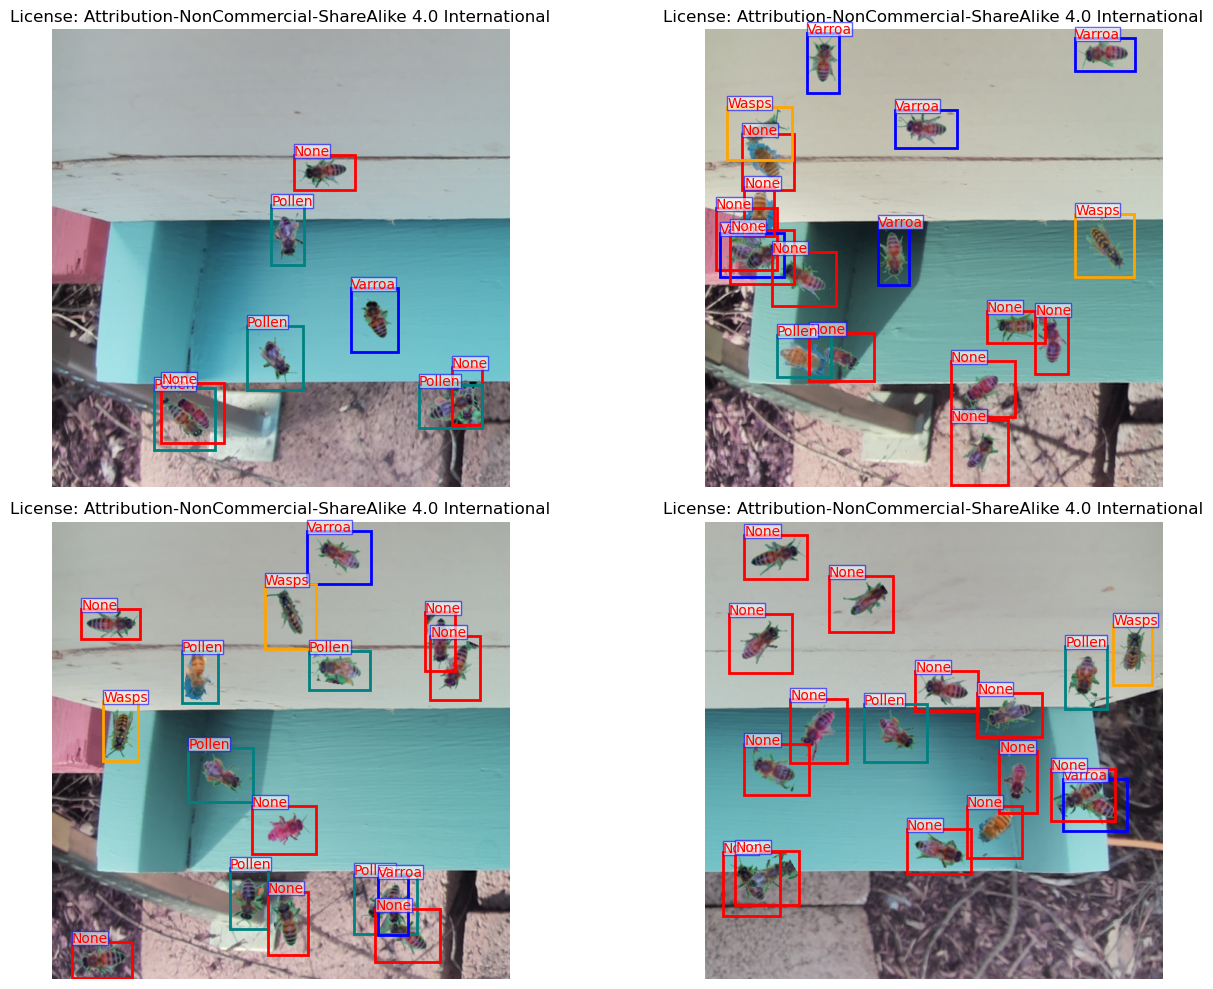

In [8]:
coco_annotations_file=train_augmented_fp + "/custom_bee_dataset.json"
coco_images_dir=os.getcwd() + "\\" + train_augmented_fp
coco= COCOParser(coco_annotations_file, coco_images_dir)

# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(0)}.png")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        _bbox = ann['bbox']
        x, y, w, h = [int(b) for b in _bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        _license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {_license}")
plt.tight_layout()
plt.show()